using time 2016-03-16 21:13:53
buffer by 60
using range (Mar 16 16 21:12:53 , Mar 16 16 21:14:53 )
found 94 2016-03-16 21:13:53
found 99 2016-03-16 21:13:53


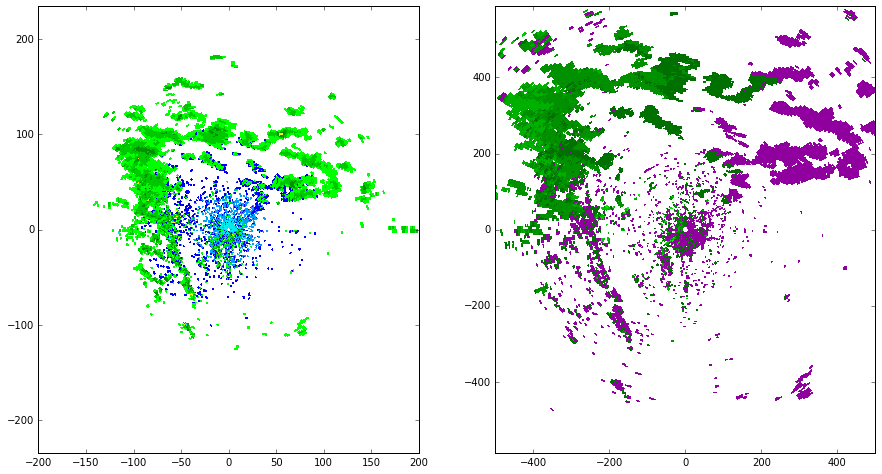

In [23]:
from awips.dataaccess import DataAccessLayer
from awips import ThriftClient, RadarCommon

from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma

# use metpy for color table
from metpy.plots import ctables

# Set EDEX server and radar site
edex = "edex-cloud.unidata.ucar.edu"
site = "kftg"

DataAccessLayer.changeEDEXHost(edex)

request = DataAccessLayer.newDataRequest()
request.setDatatype("radar")
request.setLocationNames(site)

datatimes = DataAccessLayer.getAvailableTimes(request)

# Get last available time
timerange = datatimes[-1].validPeriod
dateTimeStr = str(datatimes[-1])

# Buffer length in seconds
buffer = 60
dateTime = datetime.strptime(dateTimeStr, "%Y-%m-%d %H:%M:%S")
beginRange = dateTime - timedelta(0, buffer)
endRange = dateTime + timedelta(0, buffer)
timerange = TimeRange(beginRange, endRange)

print "using time",dateTimeStr
print "buffer by",buffer
print "using range",timerange

client = ThriftClient.ThriftClient(edex)
request = GetRadarDataRecordRequest()
request.setRadarId(site)
request.setPrimaryElevationAngle("0.5")
request.setTimeRange(timerange)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for v, ctable, ax in zip((94, 99), ('NWSReflectivity', 'NWSVelocity'), axes):
    request.setProductCode(v)
    response = client.sendRequest(request)
    if response.getData():
        for record in response.getData():
            idra = record.getHdf5Data()
            rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
            dim = rdat.getDimension()
            yLen,xLen = rdat.getSizes()
            array = rdat.getByteData()
            
            # get data for azimuth angles if we have them.
            if azdat :
                azVals = azdat.getFloatData()
                az = np.array(RadarCommon.encode_radial(azVals))
                dattyp = RadarCommon.get_data_type(azdat)
                az = np.append(az,az[-1])
                
            print "found",v,record.getDataTime()

            header = RadarCommon.get_header(record, format, xLen, yLen, azdat, "description")
            rng = np.linspace(0, xLen, xLen + 1)
            xlocs = rng * np.sin(np.deg2rad(az[:, np.newaxis]))
            ylocs = rng * np.cos(np.deg2rad(az[:, np.newaxis]))
            multiArray = np.reshape(array, (-1, xLen))
            data = ma.array(multiArray)
            data[data==0] = ma.masked

            # Plot the data
            norm, cmap = ctables.registry.get_with_steps(ctable, 16, 16)
            ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap)
            ax.set_aspect('equal', 'datalim')
            
            multp = 100*(2*xLen/460)
            ax.set_xlim(-multp,multp)
            ax.set_ylim(-multp,multp)
            # This is setting x/ylim on gate/pixel and not km


plt.show()